# Satellite Damage Classification by Transfer Learning

- Author : Yendoubouam Alexandre Lalle
- Date : 23/03/2025
- Description :
This Deep Learning project aims to explore and implement transfer learning methods to automate the annotation of damage in post-disaster satellite images.


## Imports and Configuration

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import numpy as np
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

print("Nombre de GPU disponibles :", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilisation du device :", device)

c:\Users\HP 450 G6\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nombre de GPU disponibles : 1
Utilisation du device : cuda


## Data Preparation and Transformations


In [ ]:
# Update transformations to use the standard size 224x224 (ImageNet)
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Adapt these paths according to your environment
data_dir = "./"  # root folder containing "train_another", "validation_another", and "test_another"
train_dir = os.path.join(data_dir, "train_another")
val_dir = os.path.join(data_dir, "validation_another")
test_dir = os.path.join(data_dir, "test_another")

# Create datasets (the subfolders "damage" and "no_damage" will be automatically used)
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)


## Approche A – Feature Extraction and Classification via RandomForest and XGBoost


In [ ]:
# Pour l'extraction de features, on utilise un batch petit pour économiser la mémoire
batch_size_ex = 16
train_loader_ex = DataLoader(train_dataset, batch_size=batch_size_ex, shuffle=False, num_workers=4)
val_loader_ex = DataLoader(val_dataset, batch_size=batch_size_ex, shuffle=False, num_workers=4)
test_loader_ex = DataLoader(test_dataset, batch_size=batch_size_ex, shuffle=False, num_workers=4)


In [ ]:

def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            if len(outputs.shape) > 2:
                outputs = torch.flatten(outputs, start_dim=1)
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Préparation des extracteurs de features
# Modèle 1 : ResNet50 pré-entraîné – on retire la dernière couche fully-connected
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)

# Modèle 2 : Vision Transformer (vit_b_16)
vit = vit_b_16(pretrained=True)
if hasattr(vit, 'heads'):
    vit.heads = nn.Identity()
elif hasattr(vit, 'fc'):
    vit.fc = nn.Identity()
vit = vit.to(device)

# Extraction des features pour chaque modèle
print("Extraction des features avec ResNet50...")
train_features_resnet, train_labels = extract_features(resnet, train_loader_ex, device)
val_features_resnet, val_labels = extract_features(resnet, val_loader_ex, device)
test_features_resnet, test_labels = extract_features(resnet, test_loader_ex, device)

print("Extraction des features avec Vision Transformer...")
train_features_vit, _ = extract_features(vit, train_loader_ex, device)
val_features_vit, _ = extract_features(vit, val_loader_ex, device)
test_features_vit, _ = extract_features(vit, test_loader_ex, device)


c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get 

Extraction des features avec ResNet50...
Extraction des features avec Vision Transformer...


### Saving Features

In [ ]:
# Sauvegarde des features dans un dossier "utils"
utils_dir = "utils"
os.makedirs(utils_dir, exist_ok=True)

# Sauvegarde des features pour ResNet
np.savez(os.path.join(utils_dir, "train_features_resnet.npz"),
         features=train_features_resnet, labels=train_labels)
np.savez(os.path.join(utils_dir, "val_features_resnet.npz"),
         features=val_features_resnet, labels=val_labels)
np.savez(os.path.join(utils_dir, "test_features_resnet.npz"),
         features=test_features_resnet, labels=test_labels)

# Sauvegarde des features pour Vision Transformer
np.savez(os.path.join(utils_dir, "train_features_vit.npz"),
         features=train_features_vit, labels=train_labels)
np.savez(os.path.join(utils_dir, "val_features_vit.npz"),
         features=val_features_vit, labels=val_labels)
np.savez(os.path.join(utils_dir, "test_features_vit.npz"),
         features=test_features_vit, labels=test_labels)

print("Features sauvegardées dans le dossier 'utils'.")

Features sauvegardées dans le dossier 'utils'.


In [11]:
# Chargement des features et labels sauvegardés
utils_dir = "utils"

# Chargement des features et labels pour ResNet
train_data_resnet = np.load(os.path.join(utils_dir, "train_features_resnet.npz"))
train_features_resnet = train_data_resnet["features"]
train_labels_resnet = train_data_resnet["labels"]

val_data_resnet = np.load(os.path.join(utils_dir, "val_features_resnet.npz"))
val_features_resnet = val_data_resnet["features"]
val_labels_resnet = val_data_resnet["labels"]

test_data_resnet = np.load(os.path.join(utils_dir, "test_features_resnet.npz"))
test_features_resnet = test_data_resnet["features"]
test_labels_resnet = test_data_resnet["labels"]

# Chargement des features et labels pour ViT
train_data_vit = np.load(os.path.join(utils_dir, "train_features_vit.npz"))
train_features_vit = train_data_vit["features"]
train_labels_vit = train_data_vit["labels"]

val_data_vit = np.load(os.path.join(utils_dir, "val_features_vit.npz"))
val_features_vit = val_data_vit["features"]
val_labels_vit = val_data_vit["labels"]

test_data_vit = np.load(os.path.join(utils_dir, "test_features_vit.npz"))
test_features_vit = test_data_vit["features"]
test_labels_vit = test_data_vit["labels"]

print("Train features ResNet:", train_features_resnet.shape)
print("Validation features ResNet:", val_features_resnet.shape)
print("Test features ResNet:", test_features_resnet.shape)
print("Train features ViT:", train_features_vit.shape)
print("Validation features ViT:", val_features_vit.shape)
print("Test features ViT:", test_features_vit.shape)


Train features ResNet: (10000, 2048)
Validation features ResNet: (2000, 2048)
Test features ResNet: (9000, 2048)
Train features ViT: (10000, 768)
Validation features ViT: (2000, 768)
Test features ViT: (9000, 768)


In [ ]:

def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, classifier, classifier_name, model_name):
    print("=== {} sur les features de {} ===".format(classifier_name, model_name))
    clf = classifier
    clf.fit(X_train, y_train)
    
    # Prédictions probabilistes
    y_val_proba = clf.predict_proba(X_val)[:, 1]
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calcul de l'AUC
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    auc_val = auc(fpr_val, tpr_val)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    auc_test = auc(fpr_test, tpr_test)
    
    # Calcul des accuracies (seuil à 0.5)
    y_val_pred = (y_val_proba > 0.5).astype(int)
    accuracy_val = np.mean(y_val_pred == y_val)
    y_test_pred = (y_test_proba > 0.5).astype(int)
    accuracy_test = np.mean(y_test_pred == y_test)
    
    print("Validation AUC: {:.3f}".format(auc_val))
    print("Validation Accuracy: {:.3f}".format(accuracy_val))
    print("Test AUC: {:.3f}".format(auc_test))
    print("Test Accuracy: {:.3f}".format(accuracy_test))
    
    plt.figure()
    plt.plot(fpr_test, tpr_test, label='{} ({})'.format(classifier_name, model_name))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - {} sur {}".format(classifier_name, model_name))
    plt.legend(loc="best")
    plt.show()


### Classification on Features Extracted from ResNet50

=== Random Forest sur les features de ResNet50 ===
Validation AUC: 0.918
Validation Accuracy: 0.799
Test AUC: 0.918
Test Accuracy: 0.709


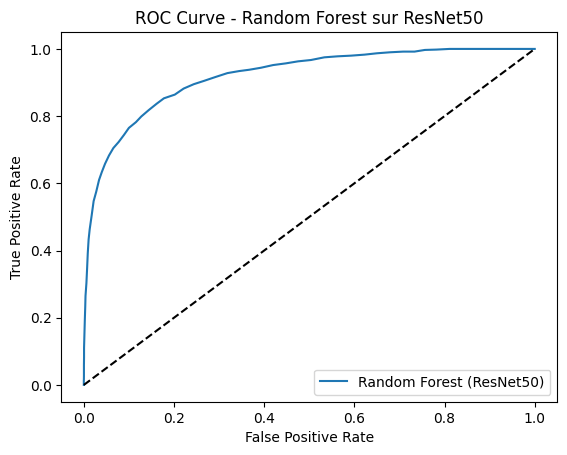

=== XGBoost sur les features de ResNet50 ===


c:\Users\HP 450 G6\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation AUC: 0.961
Validation Accuracy: 0.875
Test AUC: 0.959
Test Accuracy: 0.843


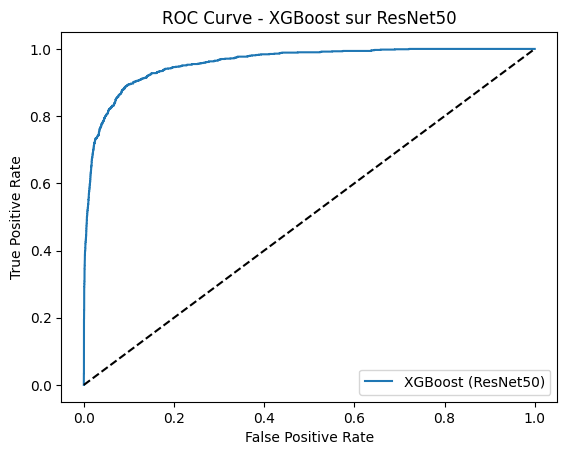

In [12]:

# Classification sur les features extraites de ResNet50
rf_resnet = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_resnet = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

train_and_evaluate_classifier(train_features_resnet, train_labels_resnet,
                              val_features_resnet, val_labels_resnet,
                              test_features_resnet, test_labels_resnet,
                              rf_resnet, "Random Forest", "ResNet50")

train_and_evaluate_classifier(train_features_resnet, train_labels_resnet,
                              val_features_resnet, val_labels_resnet,
                              test_features_resnet, test_labels_resnet,
                              xgb_resnet, "XGBoost", "ResNet50")


### Classification on Features Extracted from Vision Transformer

=== Random Forest sur les features de ViT ===
Validation AUC: 0.956
Validation Accuracy: 0.853
Test AUC: 0.953
Test Accuracy: 0.795


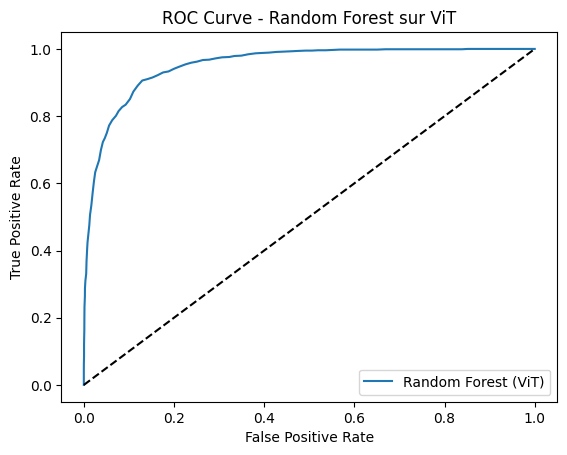

=== XGBoost sur les features de ViT ===


c:\Users\HP 450 G6\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:22:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation AUC: 0.984
Validation Accuracy: 0.931
Test AUC: 0.981
Test Accuracy: 0.900


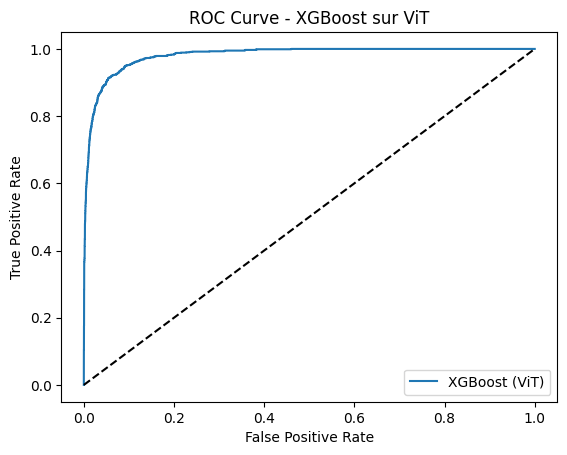

In [ ]:
rf_vit = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_vit = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

train_and_evaluate_classifier(train_features_vit, train_labels_vit,
                              val_features_vit, val_labels_vit,
                              test_features_vit, test_labels_vit,
                              rf_vit, "Random Forest", "ViT")

train_and_evaluate_classifier(train_features_vit, train_labels_vit,
                              val_features_vit, val_labels_vit,
                              test_features_vit, test_labels_vit,
                              xgb_vit, "XGBoost", "ViT")


In [ ]:
# Vider le cache GPU pour libérer la mémoire
torch.cuda.empty_cache()

## Approche B – Fine-tuning Pre-trained Models


In [4]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_auc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            all_labels = []
            all_probs = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.5).float()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().detach().numpy())
            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            fpr, tpr, _ = roc_curve(np.array(all_labels), np.array(all_probs))
            epoch_auc = auc(fpr, tpr)
            print("{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_auc))
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                if epoch_auc > best_auc:
                    best_auc = epoch_auc
                    best_model_wts = model.state_dict()
        print()
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

def modify_model(model, model_type="cnn"):
    if model_type == "cnn":
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
    elif model_type == "vit":
        if hasattr(model, 'heads'):
            model.heads = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(model.heads.head.in_features, 1)
            )
        elif hasattr(model, 'fc'):
            num_ftrs = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_ftrs, 1)
            )
    return model

# On réduit le batch size pour le fine-tuning afin d'alléger la mémoire GPU
batch_size_ft = 16
ft_train_loader = DataLoader(train_dataset, batch_size=batch_size_ft, shuffle=True, num_workers=4)
ft_val_loader = DataLoader(val_dataset, batch_size=batch_size_ft, shuffle=False, num_workers=4)
ft_test_loader = DataLoader(test_dataset, batch_size=batch_size_ft, shuffle=False, num_workers=4)

dataloaders_ft = {
    'train': ft_train_loader,
    'val': ft_val_loader
}


### Fine-tuning ResNet50

Fine-tuning de ResNet50...


c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torch\nn\modules\module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch 1/10
train Loss: 0.2220 Acc: 0.9096 AUC: 0.9702
val Loss: 0.0656 Acc: 0.9765 AUC: 0.9976

Epoch 2/10
train Loss: 0.1458 Acc: 0.9419 AUC: 0.9869
val Loss: 0.0623 Acc: 0.9770 AUC: 0.9978

Epoch 3/10
train Loss: 0.1266 Acc: 0.9515 AUC: 0.9900
val Loss: 0.0558 Acc: 0.9775 AUC: 0.9981

Epoch 4/10
train Loss: 0.1112 Acc: 0.9566 AUC: 0.9923
val Loss: 0.0527 Acc: 0.9795 AUC: 0.9987

Epoch 5/10
train Loss: 0.0959 Acc: 0.9624 AUC: 0.9942
val Loss: 0.0802 Acc: 0.9770 AUC: 0.9967

Epoch 6/10
train Loss: 0.1036 Acc: 0.9606 AUC: 0.9932
val Loss: 0.0582 Acc: 0.9805 AUC: 0.9977

Epoch 7/10
train Loss: 0.0817 Acc: 0.9693 AUC: 0.9959
val Loss: 0.0462 Acc: 0.9850 AUC: 0.9988

Epoch 8/10
train Loss: 0.0934 Acc: 0.9662 AUC: 0.9944
val Loss: 0.0310 Acc: 0.9905 AUC: 0.9995

Epoch 9/10
train Loss: 0.0780 Acc: 0.9692 AUC: 0.9961
val Loss: 0.0467 Acc: 0.9840 AUC: 0.9992

Epoch 10/10
train Loss: 0.0873 Acc: 0.9676 AUC: 0.9952
val Loss: 0.0315 Acc: 0.9895 AUC: 0.9995

Modèle ResNet50 fine-tuné sauvegardé so

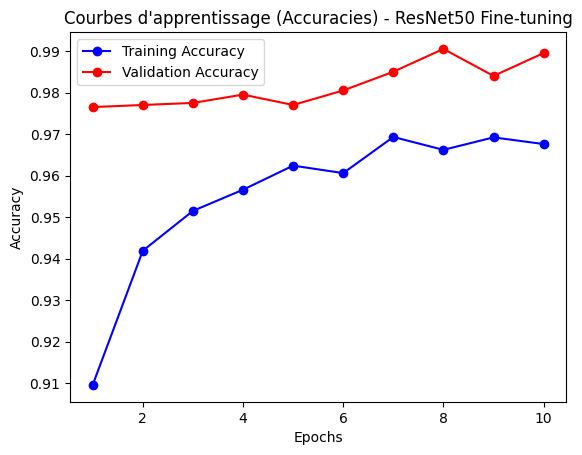

In [ ]:
print("Fine-tuning ResNet50...")
resnet_ft = models.resnet50(pretrained=True)
resnet_ft = modify_model(resnet_ft, model_type="cnn")
resnet_ft = resnet_ft.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_ft.parameters(), lr=1e-4)
num_epochs = 10
resnet_ft, train_loss_resnet, val_loss_resnet, train_acc_resnet, val_acc_resnet = train_model(
    resnet_ft, dataloaders_ft, criterion, optimizer, num_epochs=num_epochs)

# Saving the fine-tuned ResNet50 model
torch.save(resnet_ft.state_dict(), "resnet50_finetuned.pt")
print("Modèle ResNet50 fine-tuné sauvegardé sous 'resnet50_finetuned.pt'.")

# Affichage des courbes d'apprentissage pour ResNet50 fine-tuné
epochs_range = range(1, num_epochs+1)
plt.figure()
plt.plot(epochs_range, train_acc_resnet, 'bo-', label="Training Accuracy")
plt.plot(epochs_range, val_acc_resnet, 'ro-', label="Validation Accuracy")
plt.title("Courbes d'apprentissage (Accuracies) - ResNet50 Fine-tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [8]:
# Charger le modèle fine-tuné ResNet50
resnet_ft = models.resnet50(pretrained=False)
resnet_ft = modify_model(resnet_ft, model_type="cnn")
resnet_ft.load_state_dict(torch.load("resnet50_finetuned.pt", map_location=device))
resnet_ft = resnet_ft.to(device)

c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test AUC pour ResNet50 fine-tuné: 0.999
Test Accuracy pour ResNet50 fine-tuné: 0.983


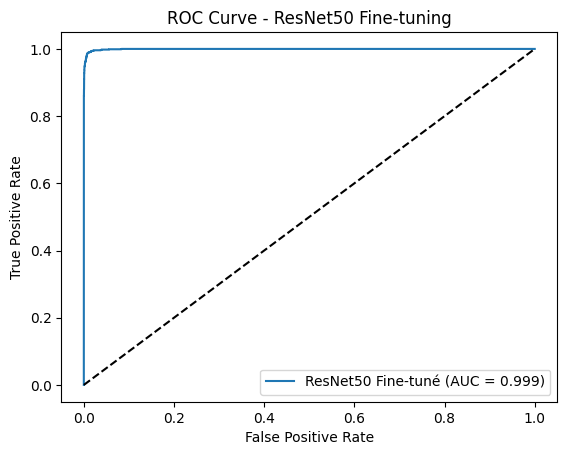

In [ ]:
resnet_ft.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in ft_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = resnet_ft(inputs)
        probs = torch.sigmoid(outputs)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calcul de l'AUC
fpr_resnet, tpr_resnet, _ = roc_curve(np.array(all_labels), np.array(all_probs))
auc_resnet = auc(fpr_resnet, tpr_resnet)
print("Test AUC pour ResNet50 fine-tuné: {:.3f}".format(auc_resnet))

# Calcul de l'accuracy
all_preds = (np.array(all_probs) > 0.5).astype(int)
accuracy_resnet = np.mean(all_preds == np.array(all_labels))
print("Test Accuracy pour ResNet50 fine-tuné: {:.3f}".format(accuracy_resnet))

plt.figure()
plt.plot(fpr_resnet, tpr_resnet, label="ResNet50 Fine-tuné (AUC = {:.3f})".format(auc_resnet))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50 Fine-tuning")
plt.legend(loc="best")
plt.show()


### Fine-tuning Vision Transformer

Fine-tuning du Vision Transformer (ViT-Tiny)...


c:\Users\HP 450 G6\miniconda3\Lib\site-packages\torch\nn\modules\module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch 1/10
train Loss: 0.2401 Acc: 0.9013 AUC: 0.9662
val Loss: 0.0715 Acc: 0.9685 AUC: 0.9979

Epoch 2/10
train Loss: 0.1255 Acc: 0.9517 AUC: 0.9903
val Loss: 0.1347 Acc: 0.9615 AUC: 0.9973

Epoch 3/10
train Loss: 0.1076 Acc: 0.9585 AUC: 0.9928
val Loss: 0.0496 Acc: 0.9805 AUC: 0.9991

Epoch 4/10
train Loss: 0.0867 Acc: 0.9669 AUC: 0.9953
val Loss: 0.1048 Acc: 0.9625 AUC: 0.9984

Epoch 5/10
train Loss: 0.0798 Acc: 0.9712 AUC: 0.9959
val Loss: 0.0424 Acc: 0.9850 AUC: 0.9989

Epoch 6/10
train Loss: 0.0784 Acc: 0.9691 AUC: 0.9962
val Loss: 0.0413 Acc: 0.9865 AUC: 0.9992

Epoch 7/10
train Loss: 0.0773 Acc: 0.9694 AUC: 0.9963
val Loss: 0.0367 Acc: 0.9885 AUC: 0.9994

Epoch 8/10
train Loss: 0.0711 Acc: 0.9730 AUC: 0.9967
val Loss: 0.0346 Acc: 0.9885 AUC: 0.9993

Epoch 9/10
train Loss: 0.0627 Acc: 0.9755 AUC: 0.9976
val Loss: 0.0399 Acc: 0.9845 AUC: 0.9994

Epoch 10/10
train Loss: 0.0639 Acc: 0.9754 AUC: 0.9974
val Loss: 0.0394 Acc: 0.9855 AUC: 0.9992

Modèle ViT-Tiny fine-tuné sauvegardé so

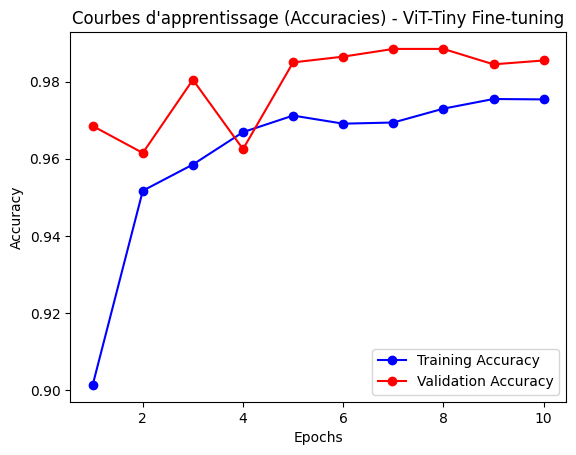

In [5]:
print("Fine-tuning du Vision Transformer (ViT-Tiny)...")
vit_ft = timm.create_model('vit_tiny_patch16_224', pretrained=True)
# Modifier la tête pour une classification binaire
num_features = vit_ft.head.in_features
vit_ft.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1)
)
vit_ft = vit_ft.to(device)

criterion = nn.BCEWithLogitsLoss()
num_epochs = 10
optimizer = optim.Adam(vit_ft.parameters(), lr=1e-4)
vit_ft, train_loss_vit, val_loss_vit, train_acc_vit, val_acc_vit = train_model(
    vit_ft, dataloaders_ft, criterion, optimizer, num_epochs=num_epochs)

# Sauvegarder le modèle fine-tuné du Vision Transformer (ViT-Tiny)
torch.save(vit_ft.state_dict(), "vit_tiny_finetuned.pt")
print("Modèle ViT-Tiny fine-tuné sauvegardé sous 'vit_tiny_finetuned.pt'.")

epochs_range = range(1, num_epochs+1)
plt.figure()
plt.plot(epochs_range, train_acc_vit, 'bo-', label="Training Accuracy")
plt.plot(epochs_range, val_acc_vit, 'ro-', label="Validation Accuracy")
plt.title("Courbes d'apprentissage (Accuracies) - ViT-Tiny Fine-tuning")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Test AUC pour ViT fine-tuné: 0.999


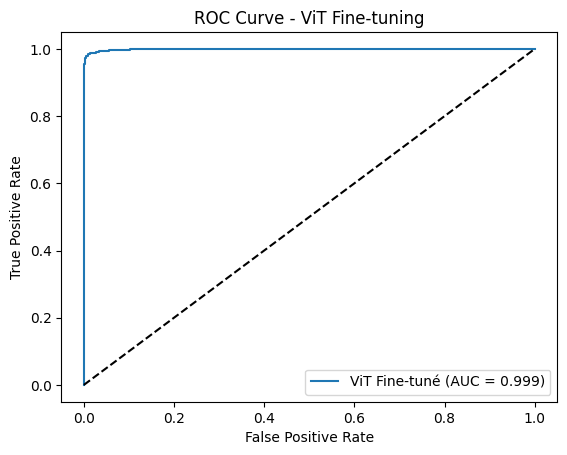

In [6]:

vit_ft.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in ft_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = vit_ft(inputs)
        probs = torch.sigmoid(outputs)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
fpr_vit, tpr_vit, _ = roc_curve(np.array(all_labels), np.array(all_probs))
auc_vit = auc(fpr_vit, tpr_vit)
print("Test AUC pour ViT fine-tuné: {:.3f}".format(auc_vit))
plt.figure()
plt.plot(fpr_vit, tpr_vit, label="ViT Fine-tuné (AUC = {:.3f})".format(auc_vit))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ViT Fine-tuning")
plt.legend(loc="best")
plt.show()


In [7]:
# Calcul de l'accuracy
# Pour la classification binaire, on considère la classe 1 si la probabilité > 0.5
all_preds = (np.array(all_probs) > 0.5).astype(int)
accuracy_vit = np.mean(all_preds == np.array(all_labels))
print("Test Accuracy pour ViT fine-tuné: {:.3f}".format(accuracy_vit))

Test Accuracy pour ViT fine-tuné: 0.981
